<a href="https://colab.research.google.com/github/qkrtnwjd4212/2023_DeepLearning_Project/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 라이브러리 import & 구글 드라이브 연결

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
from tqdm.auto import tqdm
import librosa

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras import optimizers

In [ ]:
#gdrive 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


2. 폴더 생성 및 이동

In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks/sound_emotion"

/content/gdrive/MyDrive/Colab Notebooks/sound_emotion


In [ ]:
ls

open/  open.zip


3. 압축 해제 및 파일 확인

In [ ]:
!unzip open.zip

In [ ]:
ls

sample_submission.csv  test/  test.csv  train/  train.csv


In [ ]:
cd open

/content/gdrive/MyDrive/Colab Notebooks/sound_emotion/open


In [ ]:
pwd

'/content'

4. csv 파일 읽기

In [ ]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

5. 특징 변환: 1차원 시계열 데이터 --> 40차원 시계열 데이터

In [ ]:
# 파라미터 지정
n_MFCC = 40  # Melspectrogram 벡터를 추출할 개수 -> 증가시켜보기
SR = 16000   # sample rate

# 이 두 변수 조정해가면서 확인해보기
frame_length = 0.030   # 윈도우 크기 -> 증가시켜보기
frame_stride = 0.010   # 윈도우 간격 -> 감소시켜보기

input_nfft = int(round(SR*frame_length)) # 커질수록 더 넓은 주파수 영역 커버함

input_stride = int(round(SR*frame_stride)) # 작을수록 변화를 더 잘 포착함

In [ ]:
print(input_nfft, input_stride)

480 160


In [ ]:
#MFCC 특징 추출
def get_MFCC_features(df, frame_length, frame_stride):
  x = np.zeros((df['path'].shape[0],n_MFCC,201))
  for i, path in enumerate(tqdm(df['path'])):
    print('.',end='')  # 활동없음으로 코랩 연결이 끊어질 시 주석해제
    y, sr = librosa.load(path, sr=None)

    #D = np.abs(librosa.stft(y, n_fft=2048, win_length = 2048, hop_length=1024))

    S = librosa.feature.melspectrogram(y=y, n_mels=n_MFCC, n_fft=input_nfft, hop_length=input_stride)
    S = librosa.power_to_db(S, ref=np.max)  #로그스케일(DB)로 진행하려면 주석 제거

    if S.shape[1]>= x.shape[2]:
      x[i,:,:] = S[:,:x.shape[-1]]
    else:
      x[i,:,:S.shape[1]] = S

  return x

In [ ]:
x_train = get_MFCC_features(train_df, frame_length, frame_stride)
x_test  = get_MFCC_features(test_df, frame_length, frame_stride)

  0%|          | 0/5001 [00:00<?, ?it/s]

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

6. 변환된 데이터 저장

In [ ]:
filename_x_train = 'x_train_nonlog.npy'
filename_x_test = 'x_test_nonlog.npy'
filename_y_train = 'y_train.npy'

In [ ]:
np.save(filename_x_train,x_train)
np.save(filename_x_test,x_test)
np.save(filename_y_train,np.array(train_df['label']))

7. 데이터 읽기

In [ ]:
x_train = np.load(filename_x_train)
x_test = np.load(filename_x_test)
y_train = np.load(filename_y_train)

fear


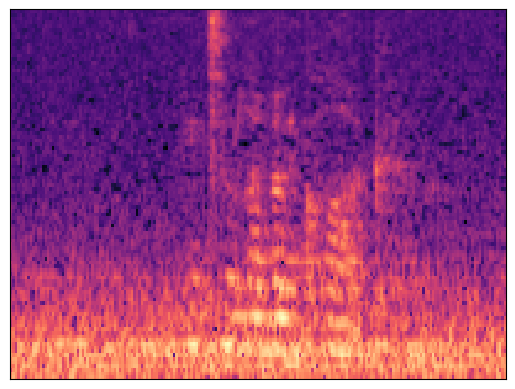

In [ ]:
#데이터 확인
dic = {0: 'angry', 1: 'fear', 2: 'sad', 3: 'disgust', 4: 'neutral', 5: 'happy'}
idx = 0
librosa.display.specshow(x_train[idx,:,:], sr=SR, hop_length=input_stride)
print(dic[y_train[idx]])

8. 정규화

In [ ]:
# Min-Max 정규화
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)
x_train = (x_train - x_train_min)/ (x_train_max- x_train_min)
x_test = (x_test - x_train_min)/ (x_train_max- x_train_min)

# Z-score 정규화
# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)
# x_train = (x_train - x_train_mean) / x_train_std
# x_test = (x_test - x_train_mean) / x_train_std

In [ ]:
# 학습데이터 2143번은 녹음되지 않은 빈 데이터로 neutral (4) 로 re-labeling한다.
x_train[2143,:,:] = 0
y_train[2143] = 4

9. 원-핫 인코딩

In [ ]:
y_train = to_categorical(y_train)

In [ ]:
# np.argmax((np.sum(np.sum(np.isnan(x_train),2),-1)))
x_train.shape

(5001, 100, 201)

10. Conv2D를 사용하기 위하여 차원 증가

In [ ]:
x_train = np.expand_dims(x_train,-1)

11. 데이터 확인

neutral


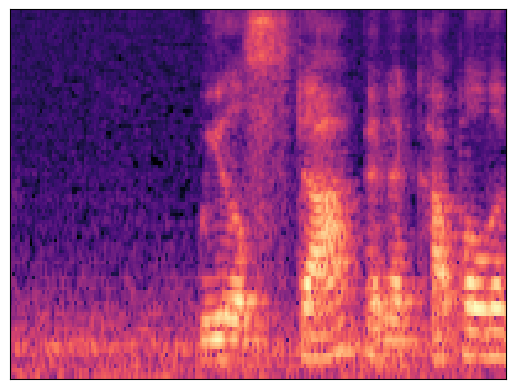

In [ ]:
dic = {0: 'angry', 1: 'fear', 2: 'sad', 3: 'disgust', 4: 'neutral', 5: 'happy'}
idx = 2
librosa.display.specshow(x_train[idx,:,:,0], sr=SR, hop_length=input_stride)
print(dic[np.argmax(y_train[idx,:])])

12. 딥러닝 모델 생성

In [ ]:
model = Sequential()
model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=[40,201,1]))
model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization()) # 합성곱 층 사이에 배치 정규화 층 추가
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Dropout(0.3)) # 드롭아웃층 : 오버피팅 방지
model.add(layers.Flatten()) # 다차원 -> 1차원 형태로 변환
model.add(layers.Dense(units=100, activation='relu'))
#model.add(layers.LayerNormalization())  # Layer 정규화 층
model.add(layers.Dense(units=y_train.shape[1], activation='softmax'))

# 오버피팅 줄이기
# 합성곱 층 개수, 필터 개수 줄여보기, 유닛수 줄여보기, 드롭아웃층 비율 늘려보기

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
# 학습률 : 보통 0.001에서 0.01 사이의 값 사용

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 100, 201, 16)      160       
                                                                 
 conv2d_33 (Conv2D)          (None, 100, 201, 16)      2320      
                                                                 
 batch_normalization_16 (Bat  (None, 100, 201, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 100, 32)       4640      
                                                                 
 conv2d_35 (Conv2D)          (None, 50, 100, 32)      

13. 학습

In [ ]:
from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# 모델 학습 시 EarlyStopping 콜백 지정
hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# 에포크 수 : 많을수록 오버피팅
# 배치 크기 : 커질수록 오버피팅

Epoch 1/100
32/32 [==============================] - 8s 196ms/step - loss: 2.5232 - accuracy: 0.3203 - val_loss: 8.8744 - val_accuracy: 0.1638
Epoch 2/100
32/32 [==============================] - 5s 168ms/step - loss: 1.5169 - accuracy: 0.3625 - val_loss: 14.8034 - val_accuracy: 0.1638
Epoch 3/100
32/32 [==============================] - 5s 165ms/step - loss: 1.4674 - accuracy: 0.3902 - val_loss: 17.0655 - val_accuracy: 0.1638
Epoch 4/100
32/32 [==============================] - 5s 167ms/step - loss: 1.4319 - accuracy: 0.4173 - val_loss: 15.4806 - val_accuracy: 0.1638
Epoch 5/100
32/32 [==============================] - 5s 170ms/step - loss: 1.3904 - accuracy: 0.4392 - val_loss: 14.5269 - val_accuracy: 0.1638
Epoch 6/100
32/32 [==============================] - 5s 166ms/step - loss: 1.3615 - accuracy: 0.4412 - val_loss: 21.3267 - val_accuracy: 0.1638
Epoch 7/100
32/32 [==============================] - 5s 169ms/step - loss: 1.2963 - accuracy: 0.4787 - val_loss: 21.1735 - val_accuracy: 

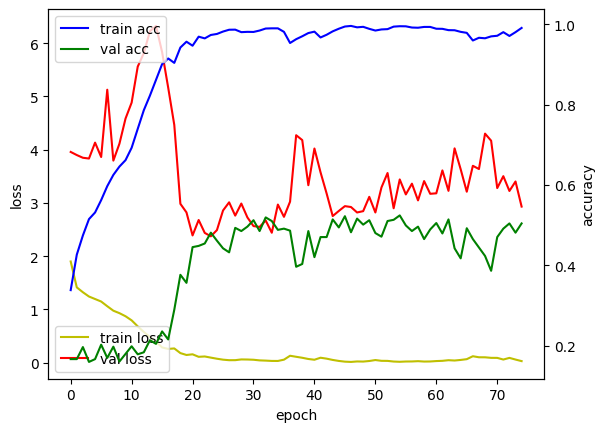

In [ ]:
# 결과 시각화

import matplotlib.pyplot as plt

def drawHistory(hist):
  fig = plt.figure()
  loss_ax = plt.gca()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='lower left')

  acc_ax.plot(hist.history['accuracy'],'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'],'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='upper left')

  plt.show()


drawHistory(hist)

14. 예측

In [ ]:
o = model.predict(x_test)

59/59 [==============================] - 1s 10ms/step


In [ ]:
o = np.argmax(o,-1)

15. DataFrame 형식으로 변환 & 파일 저장

In [ ]:
#출력을 Dataframe 형태로 변환
df_out = pd.DataFrame(o)
df_out.columns = ['label']

# passenger ID와 출력을 하나로 묶음
df_answer = pd.concat([test_df['id'],df_out], axis=1)

In [ ]:
df_answer.to_csv('answer3.csv',index=False)